# Process Inv Tumopr Data for svgs

19JAN24

In [1]:
# figdir = "/home/ckmah/d/bento-manuscript/notebooks/figure-analysis/figures"
figdir = "/home/ckmah/d/bento-manuscript/figures/breast_cancer_supp"

In [2]:
%load_ext autoreload
%autoreload 2

import random
import pandas as pd
import bento as bt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(10)

# Load the data

In [3]:
# data directory
adata = bt.io.read_h5ad("inv_tumor_crop_flux.h5ad")
adata

AnnData object with n_obs × n_vars = 626 × 541
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden_res1.0', 'cell_type', 'cell_area', 'cell_aspect_ratio', 'cell_density', 'nucleus_area', 'nucleus_aspect_ratio', 'nucleus_density', 'cell_radius', 'nucleus_radius'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_raster', 'cell_type_colors', 'dendrogram_cell_type', 'flux', 'flux_counts', 'flux_embed', 'flux_genes', 'flux_n_components', 'flux_sv', 'flux_variance_ratio', 'leiden', 'leiden_res1.0_colors', 'log1p', 'neighbors', 'pca', 'point_sets', 'points', 'rank_genes_groups', 'umap', 'wilcoxon'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts

In [4]:
valid_genes = ~(
    adata.var_names.str.startswith("BLANK")
    | adata.var_names.str.startswith("NegControl")
)
adata = adata[:, valid_genes]
bt.sync(adata)

In [5]:
flux_params = dict(res=1, alpha=True, dx=0.2125)

# RNAflux

In [6]:
def rnaFlux(adata, res=1):
    if "cell_raster" in adata.uns_keys():
        del adata.uns["cell_raster"]
    if "cell_raster" in adata.obs_keys():
        del adata.obs["cell_raster"]
    if "cell_raster" in adata.uns["point_sets"]:
        del adata.uns["point_sets"]["cell_raster"]
    # mean_radius = adata.obs["cell_radius"].mean()
    bt.tl.flux(adata, res=res, n_components=10, train_size=1)

In [7]:
rnaFlux(adata)

  0%|          | 0/626 [00:00<?, ?it/s]

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/inv_tumor_rnaflux.svg


Text(0.5, 1.0, 'Inv Tumor')

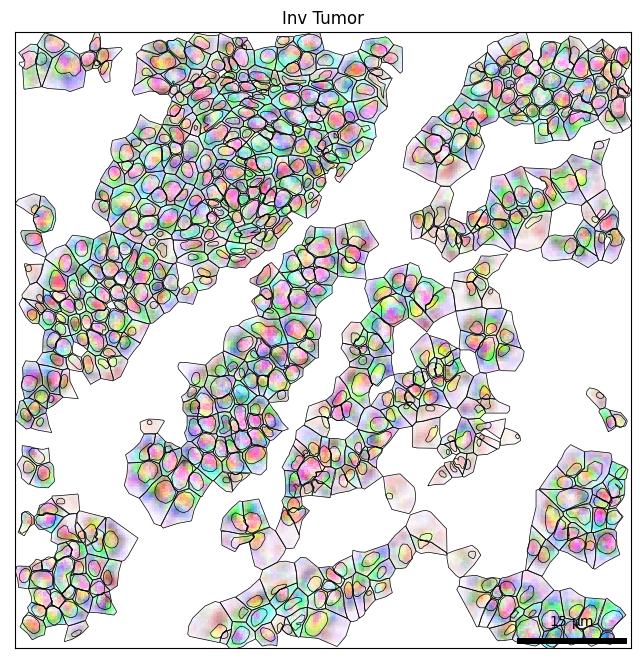

In [8]:
plt.figure(figsize=(8, 8))
bt.pl.flux(
    adata,
    **flux_params,
    fname=f"{figdir}/inv_tumor_rnaflux.svg",
)
plt.title("Inv Tumor")

# Fluxmap

In [9]:
res = 1
bt.tl.fluxmap(adata, res=res, n_clusters=3, min_points=0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/626 [00:00<?, ?it/s]

  0%|          | 0/626 [00:00<?, ?it/s]

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/inv_tumor_fluxmap.svg


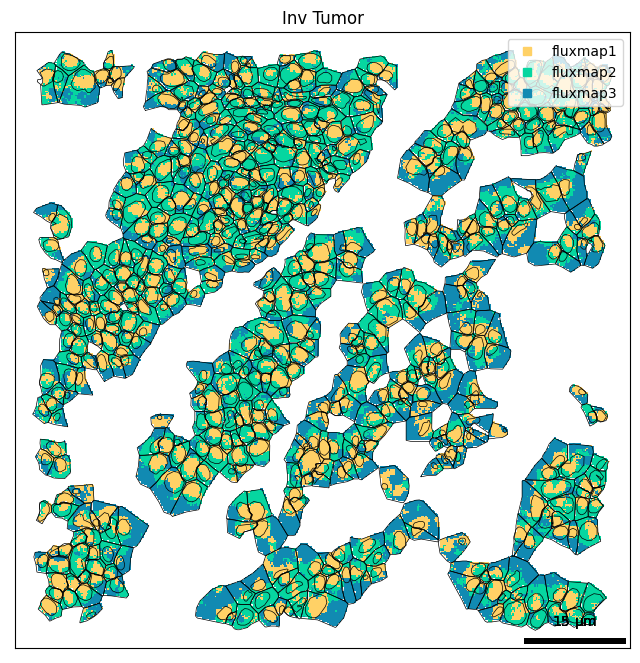

In [10]:
plt.figure(figsize=(8, 8))
bt.pl.fluxmap(
    adata,
    title="Inv Tumor",
    palette=sns.color_palette(bt.colors.bento6, n_colors=3),
    lw=0,
    dx=0.2125,
    fname=f"{figdir}/inv_tumor_fluxmap.svg",
)

### Functional enrichment of fluxmaps

Apex seq data comparison

In [11]:
adata.uns["point_sets"]["cell_raster"] = list(adata.uns["point_sets"]["cell_raster"])

In [12]:
bt.tl.fe_xia2019(adata)

7 samples of mat are empty, they will be removed.
Running wsum on mat with 86945 samples and 319 targets for 2 sources.
Infering activities on 9 batches.


100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


In [13]:
adata.uns["fe_ngenes"]

source      ER  Nucleus
n_genes  11903    11903

In [14]:
adata.uns["fe_stats"]

ER  Nucleus
cell               
3986   133      133
3987   133      133
3988   133      133
3989   133      133
3990   133      133
...    ...      ...
72555  133      133
72557  133      133
72563  133      133
72759  133      133
72766  133      133

[626 rows x 2 columns]

In [30]:
@bt.pl._utils.savefig
def plot_domain_fe(data, fname=None):
    domains = [
        "flux_Nucleus",
        "flux_ER",
    ]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )
    domain_fe.dropna(inplace=True)
    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).mean()
    domain_fe.columns = [d.split("flux_")[1] for d in domain_fe.columns]

    # domain_fe = domain_fe.iloc[1:]

    with sns.axes_style("white"):
        fig = plt.figure(figsize=(3, 3))
        ax = sns.heatmap(
            domain_fe.T,
            center=0,
            vmin=-2,
            vmax=2,
            cmap=bt.colors.red2blue,
            square=True,
            cbar_kws=dict(shrink=0.5, aspect=10),
            # figsize=(3, 2),
        )
        ax.spines[:].set_visible(True)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)


plot_domain_fe(adata, fname=f"{figdir}/inv_tumor_domain_fe.svg")

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/inv_tumor_domain_fe.svg


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
genesets = [
    "flux_ER",
    "flux_Nucleus",
]
for gs, ax in zip(genesets, axes.flat):
    title = gs.split("_")[1]
    bt.pl.fe(
        adata,
        gs,
        shapes=["cell_shape"],
        res=1,
        vmin=-5,
        vmax=5,
        title=title,
        ax=ax,
    )
    bt.pl.shapes(adata, shapes=["fluxmap1_shape"], title=title, ax=ax)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

In [31]:
domain_palette = {
    "fluxmap1": sns.desaturate("#ef476f", 0.85),
    "fluxmap3": sns.desaturate("#FFD166", 0.85),
}


dx = 0.2

In [33]:
@bt.pl._utils.savefig
def plot_flux_fe(data, fname=None):
    domains = ["flux_Nucleus", "flux_ER"]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )

    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).mean()
    domain_fe = domain_fe.iloc[1:, :]
    fluxmap2domain = domain_fe.idxmax(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    for shape, color, ax in zip(
        fluxmap2domain.index[[0, 2]], bt.colors.bento6, axes.flat
    ):
        cmap = mpl.colors.LinearSegmentedColormap.from_list(
            "_",
            ["gray", "white", domain_palette[f"fluxmap{shape}"]],  # nuc read er yellow
        )
        domain = fluxmap2domain[shape]
        bt.pl.shapes(
            adata,
            shapes=f"fluxmap{shape}",
            facecolor="blue",
            alpha=0.05,
            lw=0.5,
            ax=ax,
            dx=dx,
        )
        bt.pl.shapes(
            adata,
            shapes=f"fluxmap{shape}",
            alpha=0.5,
            lw=0.5,
            ax=ax,
            dx=dx,
        )
        bt.pl.fe(
            adata,
            domain,
            res=1,
            cmap=cmap,
            ax=ax,
            title=domain.split("_")[1],
            shapes=["cell_shape"],
            square=True,
            vmin=-4,
            vmax=4,
            dx=dx,
        )

    # remove empty axes
    for ax in axes.flat[domain_fe.shape[0] :]:
        ax.remove()
    plt.subplots_adjust(wspace=0.05, hspace=0.1)


plot_flux_fe(adata, fname=f"{figdir}/inv_tumor_fe_domains.svg")

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/inv_tumor_fe_domains.svg


In [20]:
import geopandas as gpd
from shapely.ops import unary_union

nuclei = gpd.GeoDataFrame(geometry=bt.geo.get_shape(adata, "nucleus_shape"))
fluxmap1 = gpd.GeoDataFrame(geometry=bt.geo.get_shape(adata, "fluxmap1_shape"))
fluxmap2 = gpd.GeoDataFrame(geometry=bt.geo.get_shape(adata, "fluxmap2_shape"))
fluxmap3 = gpd.GeoDataFrame(geometry=bt.geo.get_shape(adata, "fluxmap3_shape"))


def iou(p1, p2):
    """Intersection over union"""
    return p1.intersection(p2).area / p1.union(p2).area


def io1(p1, p2):
    """Intersection over p2"""
    return p1.intersection(p2).area / p1.area


def io2(p1, p2):
    """Intersection over p2"""
    return p1.intersection(p2).area / p2.area


# intersect = gpd.overlay(nuclei, fluxmap2, how="intersection")
# union = gpd.overlay(nuclei, fluxmap2, how="union")

In [21]:
nuclei_iou = pd.DataFrame(
    [iou(nuclei, f) for f in [fluxmap1, fluxmap2, fluxmap3]],
    index=["fluxmap1", "fluxmap2", "fluxmap3"],
).T
nuclei_iou[nuclei_iou.isna()] = 0
nuclei_iou.mean()

fluxmap1    0.392507
fluxmap2    0.200664
fluxmap3    0.049578
dtype: float64

In [22]:
nuclei_io1 = pd.DataFrame(
    [io1(nuclei, f) for f in [fluxmap1, fluxmap2, fluxmap3]],
    index=["fluxmap1", "fluxmap2", "fluxmap3"],
).T
nuclei_io1[nuclei_io1.isna()] = 0
nuclei_io1.mean()

fluxmap1    0.544784
fluxmap2    0.338183
fluxmap3    0.082469
dtype: float64

In [23]:
nuclei_io2 = pd.DataFrame(
    [io2(nuclei, f) for f in [fluxmap1, fluxmap2, fluxmap3]],
    index=["fluxmap1", "fluxmap2", "fluxmap3"],
).T
nuclei_io2[nuclei_io2.isna()] = 0
nuclei_io2.mean()

fluxmap1    0.613945
fluxmap2    0.329607
fluxmap3    0.183625
dtype: float64

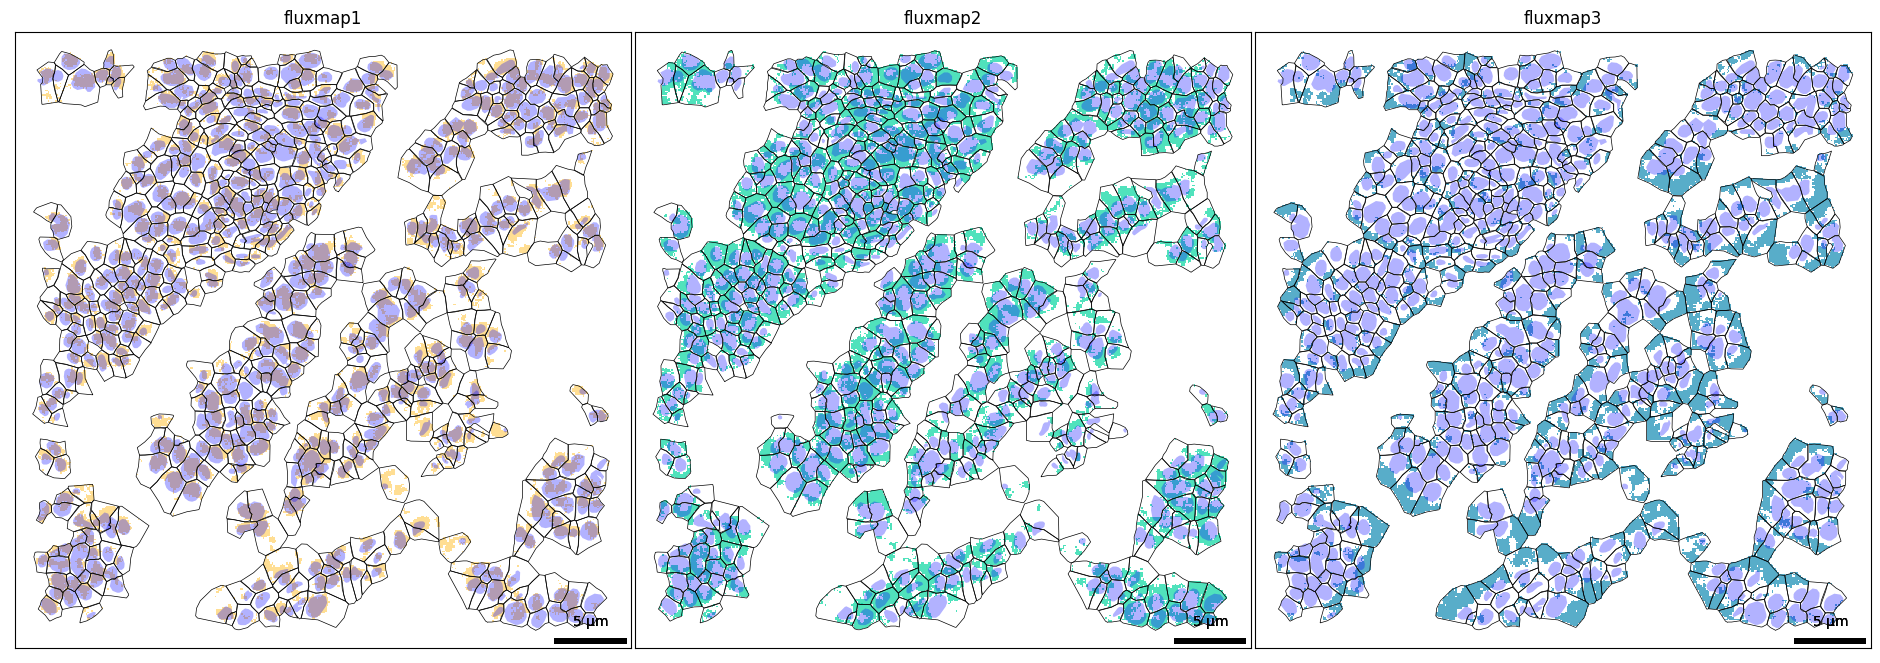

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for i, ax in zip(range(1, 4), axes.flat):
    bt.pl.shapes(
        adata,
        shapes=[f"fluxmap{i}_shape"],
        lw=0,
        facecolor=bt.colors.bento6[i - 1],
        alpha=0.7,
        ax=ax,
    )
    bt.pl.shapes(
        adata, shapes=["nucleus_shape"], lw=0, facecolor="blue", alpha=0.3, ax=ax
    )
    bt.pl.shapes(adata, shapes=["cell_shape"], ax=ax)
    ax.set_title(f"fluxmap{i}")
plt.subplots_adjust(wspace=0)

In [25]:
bt.tl.comp_diff(
    adata,
    groupby="batch",
    ref_group=0,
    shape_names=[
        "fluxmap1_shape",
        "fluxmap2_shape",
        "fluxmap3_shape",
    ],
)

In [26]:
bt.pl.flux_summary(
    adata,
    groupby="batch",
    sizes=(20, 100),
    height=6,
    fname=f"{figdir}/inv_tumor_summary.svg",
)

[13:46:20] WARNING  No handles with labels found to put in legend.                                   ]8;id=216109;file:///home/ckmah/mambaforge/envs/bento-manuscript/lib/python3.9/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=485050;file:///home/ckmah/mambaforge/envs/bento-manuscript/lib/python3.9/site-packages/matplotlib/legend.py#1225\1225]8;;\

Saved to /home/ckmah/d/bento-manuscript/figures/breast_cancer_supp/inv_tumor_summary.svg


In [27]:
import scanpy as sc

with plt.rc_context({"svg.fonttype": "none", "font.family": "Arial"}):
    sc.pl.embedding(adata, basis="spatial", color="cell_type", title="Invasive Tumor")

[13:46:21] WARNING  findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.    ]8;id=168012;file:///home/ckmah/mambaforge/envs/bento-manuscript/lib/python3.9/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=36074;file:///home/ckmah/mambaforge/envs/bento-manuscript/lib/python3.9/site-packages/matplotlib/font_manager.py#1346\1346]8;;\

           WARNING  findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.    ]8;id=262140;file:///home/ckmah/mambaforge/envs/bento-manuscript/lib/python3.9/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=998662;file:///home/ckmah/mambaforge/envs/bento-manuscript/lib/python3.9/site-packages/matplotlib/font_manager.py#1346\1346]8;;\